<a href="https://colab.research.google.com/github/NadjaKljestanovic/PPPO/blob/main/DetekcijaObjekata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Univerzitet u Novom Sadu

Fakultet tehničkih nauka

Departman za industrijsko inženjerstvo i menadžment



**Predmet**: Principi prezentacije i prepoznavanja oblika

**Tema projektnog zadatka:** Detekcija objekata - automobili

**Student:** Nađa Klještanović IT23/2020


---



**Sadržaj rada:**

1.   Uvod
  *   Mašinsko učenje
  *   Deep learning
  *   Računarska vizija
2.   Opis zadatka
3.   Teorijske osnove
  *   Detekcija objekata
  *   Bounding box
4.   Predlog rešenja problema
5.   Zaključak
6.   Reference


---



> **Uvod**


1.   **Mašinsko učenje**

Mašinsko učenje je grana veštačke inteligencije koja se bavi razvojem algoritama i tehnika koji omogućavaju računarima da uče iz podataka. Glavni cilj mašinskog učenja je da omogući računarima da detektuju obrasce u podacima i koriste ih kako bi donosili odluke ili predviđali buduće događaje.

Mašinsko učenje se koristi u različitim oblastima, kao što su prepoznavanje govora, preporučivanje proizvoda, analiza podataka i mnoge druge.

Neki osnovni koraci mašinskog učenja bi mogli biti definisani na sledeći način:


  1.   Prikupljanje podataka,
  2.   priprema podataka,
  3.   analiza rezultujućih skupova podataka,
  4.   izbor jednog ili više modela učenja,
  5.   trening ili obuka,
  6.   evaluacija modela,
  7.   konfiurisanje hiperparametara i
  8.   predviđanja.

Postoji tri tipa mašinskog učenja, a to su:

  1.   Nadgledano učenje,
  2.   nenadgledano učenje i
  3.   učenje uz podsticaje.

Razlozi primene mašinskog učenja jesu rešavanje teških problema u praksi, kao što su prepoznavanje lica ili nekih drugih objekata na fotografijama ili video zapisima, klasifikacija teksta i mašinsko prevođenje, analiza osećanja izraženih u tekstu i prepozanavnje govora [1].

3.   **Deep learning**

Deep learning predstavlja poseban pristup mašinskom učenju koji koristi duboke neuronske mreže za automatsko učenje reprezentacija podataka. Ovaj pristup učenju je podskup mašinskog učenja i prepoznaje se po neuronskim mrežama koje imaju više slojeva u odnosu na tradicionalne metode mašinskog učenja.

Duboke neuronske mreže karakteriše sposobnost automatskog izdvajanja složenih i apstraktnih reprezentacija iz podataka, što ih činin efikasnima za obradu velikih i kompleksnih skupova podataka.


Deep learning je postao ključna tehnologija u oblasti računarske vizije. Probleme kao što su prepoznavanje objekata, klasifikacija i segmentacija slika, prepoznavanje lica i mnoge druge, neuronske mreže rešavaju na impresivan način. Što se tiče analize vizuelnih podataka, CNN ili konvolucione neuronske mreže su posebno uspešne u ovoj oblasti. One efikasno identifikuju lokalne obrasce u slikama, čime se postiže visok nivo preciznosti u prepoznavanju objekata [2].

3.   **Računarska vizija**

Računarska vizija je područje veštačke inteligencije koje se bavi razvojem tehnika i algoritama koji omogućavaju računarima da interpretiraju, analiziraju i razumeju vizuelne informacije iz slika ili video snimaka. Glavni cilj računarske vizije je da omogući računarima da vide i razumeju svet oko sebe na način koji je sličan ljudskom oku, to jest vidu.

Primena računarske vizije jeste u različitim aplikacijama, kao što su aplikacije prepoznavanja lica, analiza medicinskih slika, autonomna vožnja automobila, detekcija objekata i mnoge druge.

Mašinsko učenje je opštiji pojam koji obuhvata širok spektar tehnika koje omogućavaju računarima da uče iz podataka. Računarska vizija je specifična grana mašinskog učenja koja se fokusira na obradu vizuelnih informacija.

Računarska vizija često koristi tehnike mašinskog učenja kako bi postigla svoje ciljeve. Na primer, algoritmi mašinskog učenja se često koriste za klasifikaciju objekata na slikama, detekciju lica ili prepoznavanje uzoraka na video snimcima.

Postojeći sistemi računarske vizije obavljaju pristojan posao u klasifikovanju slika i lokalizovanju objekata na fotografijama kada se obučavaju na dovoljnom broju primera. Ipak, u suštini, algoritmi dubokog učenja koji pokreću aplikacije za računarsku viziju bave se uparivanjem uzoraka piksela. Oni ne razumeju šta se događa na slikama. Razumevanje odnosa ljudi i objekata u vizuelnim podacima zahteva zdrav razum i pozadinsko znanje [3].


---



> **Opis zadatka**


Projektni zadatak na temu *Detekcija objekata - automobili* odnosi se na kreiranje modela koji će biti sposoban da prepozna traženi objekat na slici, dakle automobil, i prikaže ga korisniku na određeni način. Konkretno ovaj projektni zadatak bi trebalo da koristi tehniku *bounding box* koja će uočeni objekat na slici uokviriti pravougaonikom određenog formata.

Dobijeni dataset nad kojim bi projekat trebalo kreirati sadrži dva direktorijuma i dva *.csv* fajla. Direktorijumi sadrže slike koje će služiti za treniranje, a kasnije i za testiranje samog kreiranog modela. Datoteke namenjena treningu modela sadrži podatke o ID-ju slike sa dodeljenim koordinatama pravougaonika koji bi trebalo da opiše vozilo na slici. Što se tiče testnik podataka, struktura je identična, s tim što je u ovom fajlu naglasak na ID-jevima slika, a koordinate model sam treba da izračuna.

---


> **Teorijske osnove**


  1.   **Detekcija objekata**

Detekcija objekata na slikama je zadatak računarske vizije koja se, kao što je već rečeno, bavi prepoznavanjem i lokalizacijom različitih objekata ili entiteta unutar slika. Detekcija objekata ima veliku primenu kod autonomnih vozila, video nadzora, medicinske dijagnostike i prepoznavanja lica.

Ključni pojmovi vezani za detekciju objekata su:


*   Lokalizacija objekata,
*   klasifikacia objekata i
*   detekcija ključnih tačaka.

Lokalizacija objekata podrazumeva identifikaciju i označavanje objekta unutart slike. To se često izražava pomoću okvira (*bounding box*) koji okružuje detetkovan objekat, što će biti obrađeno u narednom pasusu projekta.

Klasifikacija objekata se vrši nakon lokalizacije, a podrazumeva određivanje klase kojoj objekat pripada. To može uključivati prepoznavanje različitih kategorija kao što su automobili, ljudi - pešaci, životinje ili bilo koje druge klase.

Ponekad je neophodno detektovati ključne tačke objekta. Pod ključnim tačkama podrazumevaju se karakteristične tačke kao što su uglovi lica na primer. Ovaj korak se često preduzima prilikom prepoznavanja gestikulacija ili analize pokreta.

Postoje različiti algoritmi koji služe za detekciju, odnosno prepoznavanje objekata. Neki od njih, koji se koriste kada želimo da radimo tehniku *bounding box*, su:

*   *YOLO* - *You Only Look Once*,
*   *SSD* - *Single Shot Multibox Detector* i
*   *Faster R-CNN* - *Region-based Convolutional Neural Network*.

*YOLO* je jednostavan i efikasan algoritam koji radi na principu da samo jednom analizira celu sliku radi detekcije objekata. Umesto tradicionalnog pristupa koji deli sliku na mrežu i analizira svaki deo zasebno, *YOLO* koristi jednu neuronsku mrežu za predviđanje *bounding box-ova* i verovatnoća pripadnosti klasi. Ovaj pristup omogućava bržu i efikasniju detekciju, ali ima problema sa preciznošću, posebno pri detekciji malih objekata.

*SSD* je jedan od često korišćenih algoritama, a njegova ključna prednost je u sposobnosti istovremenog predviđanja objekata različitih veličina u jednom prolazu kroz neuronsku mrežu. Koristi niz *default bounding box-ova* na različitim skalama i proporcijama, čime omogućava detekciju objekata različitih veličina. *SSD* često pruža dobar balans između brzine i preciznosti, a posebno je efikasan u detekciji manjih objekata. Ovaj algoritam će biti iskorišćen u narednom pasusu gde je prikazano praktično rešenje.

*Faster R-CNN* je jedan od prvih algoritama koji kombinuje *Region Proposal Network* - *RPN* sa konvolutivnim neuronskim mrežama - *CNN*. Ovaj pristup omogućava mreži da automatski generiše regione od interesa i fokusira se na delove slike gde su verovatno prisutni objekti. Nakon toga, koristi se drugi deo mreže za klasifikaciju i preciznu lokalizaciju objekata. *Faster R-CNN* ima visoku preciznost, a mana mu je to što može biti spor u odnosu na *YOLO* i *SSD* algoritme.

Svaki od navedenih algoritama ima svoje prednosti i nedostatke, a potrebe projekta (specifični zahtevi, brzina detekcije i tražena tačnost) određuju koji će se od pomenutih algoritama koristiti [4].


2.   **Bounding box**

*Bounding box* je tehnika koja se koristi za oznaku objekata detektovanih na fotografijama ili video zapisima upotrebom računarske vizije. Ograničen okvir označava objekte od interesa za model, bilo da je to čovek, životinja, saobraćajni znak, vozilo ili bilo šta drugo. Model je programiran da uči o sadržaju unutar *bounding box-a* kako bi predvideo prisustvo sličnih objekata kada je izložen novim podacima koje ranije nije video.

*Bounding box* ili granična kutija, definisana je uglavnom sa dve tačke , a to su gornji levi i donji desni ugao pravougaonika. Ove jednostavne oznake se koriste za otkrivanje objekata i lokalizaciju, pružajući jednostavan i intuitivan način za opisivanje položaja i veličine objekza na slici.

Ova tehnika se koristi uokliko želimo da detektujemo objekat na fotografiji ili pratimo objekat u videp zapisima.

Postoje različite prakse za označavanje *bounding box-ova*, a neke od njih su:

*   *Consistent labeling*,
*   *Tight boxes*,
*   *Overlapping boxes*,
*   *Occlusion and Truncation*,
*   *Label All Instances* i
*   moderni alati za označavanje.

Kod *Consistent labeling-a* ključno je osigurati da ista klasa objekata bude označena istim imenom na svim slikama u skupu podataka. Konzistentnost je neophodna za modele obuke koji mogu precizno prepozanti objekte.

*Tight boxes* podrazumeva da pravouganik mora da se nalazi čvrsto, odnosno odmah do uočenog objekta, tako da njegove ivice dodiruju granice objekta bez odsecanja njegovih delova.

Kada se objekti preklapaju ili zatvaraju, preporučuje se upotreba *Overlapping boxes*, odnosno crtanje pojedinačnih okvira oko svakog vidljivog objekta.

*Occlusion and Truncation* ima sličnu upotrebu kao prethodno navedena praksa, odnosno preporučuje se da se nacrtaju pravougaonici samo oko vidljivih delova objekata.

*Label All Instances* je metoda koja podrazumeva da je svaka instanca klase objekata označena na svakoj slici, čak iako su instance male ili delimično vidljive. To pomaže modelu da nauči da detektuje objekte pod različitim uslovima koji oponašaju stvarnost.

Moderni alati za označavanje obezbeđuju funkcije kao što su automatsko preklapanje okvira, uveličavanje i prečice na tastaturi, čineći proces efikasnijim i preciznijim. Dakle, upotreba modernih alata se preporučuje jer su oni veoma jednostavni za korišćenje, a pružaju veliku efikasnost prilikom crtanja *boundinx box-ova*.

***Bounding box* ili segmentacija**

Segmentacija jeste tehnika koja se koristi prilikom detekcije, odnosno prepoznavanja objekata kako bi sevoznačio objekat koji je lokalizovan. Nasuprot *bounding box* tehnici koja funkcioniše tako što se crta pravougaonik oko objekta, kada se koristi segmentacija, objekat bude celom svojom površinom prekriven maskom koja se ističe u odnosu na ostatak fotografije.

I jedna i druga tehnika različite svrhe u kojima se koriste, a odabir tehnike zavisi od konkretnog problema koji se rešava.

U daljem tekstu biće navedene situacije kada se favorizuje korišćenje tehnike *bounding box* u odnosu na segmentaciju:


*   Detekcija i lokalizacija objekta,
*   brža anotacija,
*   efikasnost,
*   potreba za manje detaljnim informacijama i
*   jednostavnost modela.

Ako je primarni cilj da se detektuju i lokalizuju objekti, *bounding box* je bolja tehnika jer obezbeđuje jednoszavnu i efikacnu reprezentaciju pozicije i veličine (obima) objekta.

*Bounding box-evi* se brže i lakše označavaju nego maske kod segmentacije jer one zahtevaju napomenu na nivou piksela. Ovo može biti značajna prednost pri kreiranju modela nad velikim skupom podataka.

Računska efikasnost podrazumeva to da ova tehnika zahteva manje memorije i vremena, te ih to čini pogodnijim za *realtime* aplikacije ili primenu na uređajima sa ograničenim resursima.

Kada kreiramo aplikaciju koja ne zahteva detaljne unformacije o granicama objekta ili razdvajanju objekata iste klase, pravougaonici koji se kreiraju mogu biti dovoljni. Primer takve aplikacije jeste aplikacija koja služi za detekciju pešaka ili vozila, gde nam lokacija i veličina objekta pruža sasvim dovoljno potrebnih informacija.

Što se tiče implementacije i obuke, *bounding box* modeli mogu biti jednostavniji, jer segmentacija često zahteva upotrebu složenije arhitekture i strategija obuke [5].

---

> **Predlog rešenja problema**

U narednom paragrafu biće predstavljeno jedno rešenje zadatog problema detekcije automobila na fotografijama. Takođe, detaljno će biti opisan kod koji je priložen u daljem tekstu.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prvi korak podrazumeva ostvarivanje konekcije sa *Google Drive*-om. On nam je potreban iz razloga što se na njemu nalazi dataset, odnosno svi potrebni podaci za treniranje, ali i za testiranje modela koji se kreira. Korišćenje *Google Drive*-a nam omogućava modul *drive* koji se nalazi u biblioteci *google-colab*. Njega je potrebno prvo uvesti, a zatim pozvati metodu *mount* kako bismo se povezali sa diskom radi pristupa fajlovima.

U narednoj ćeliji nalaze se svi neophodni *importi*, odnosno uvoženje svih biblioteka koje će biti korišćene. Takođe, pored svake linije nalazi se kratko objašnjenje o generalnoj svrsi biblioteke, njenih modula ili funkcija. Neposredno nakon uvoza svega što je potrebno, vrši se oslobađanje memorijskog prostora što je veoma korisno ako se koristi PyTorch.

In [51]:
import numpy as np #rad sa numeričkim nizovima
import pandas as pd #manipulacija podacima u obliku DataFrame-a
import os #manipulacija fajlovima i direktorijumima (interakcija sa operativnim sistemom)
import glob #pretraga putem wildcards-a (*)
import torch #za mašinsko učenje
import random
from torchvision.ops import nms #fukcija za eliminaciju preklapanja izlaza
import cv2 #rad sa slikama i računarskom vizijom
import PIL.Image as Image #modul za rad sa slikama
import matplotlib.pyplot as plt #modul za vizuelizaciju podataka i slika
torch.cuda.empty_cache() #funkcija za oslobađanje memorijskog prostora

Dalje, vrši se postavljanje nekih promenljivih koje će biti korišćene kroz ceo kod, a one se odnose na veličinu slike, veličinu batch-a (broj slika kojima se pristpa tokom jedne iteracije treninga), broj epoha treniranja i learning rate (stopa učenja). Kao uređaj se koristi *cuda* ako je GPU dostupan, a u suprotnom *cpu*.

In [52]:
image_size=256
batch_size=4
device='cuda' if torch.cuda.is_available() else 'cpu'
epochs= 3
lr=0.0002

Broj epoha predstavlja broj itercija kroz ceo skup podataka koje model prolazi prilikom treniranja. On bi trebalo da bude optimalan, ni previše velik, ali ni previše mali. U ovom primeru broj epoha je postavljen na 3 iz razloga što je vreme izvršavanja epohe veliko, pa da bi sam trening modela bio efikasniji. Neki broj epoha koji bi bio dobar za ovaj model jeste 40, ali, kao što je prethodno pomenuto, to oduzima mnogo vremena.

In [53]:
dir_path = '/content/drive/MyDrive/data'
csv_file = '/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv'

Prethodne dve promenljive se odnose na putanje do direktorijuma sa datasetom, kao i do *csv* fajla u kome su izlistani podaci za trening.

In [54]:
train_images = os.listdir(os.path.join(dir_path, 'training_images'))
num_train_images = len(train_images)

test_images = os.listdir(os.path.join(dir_path, 'testing_images'))
num_test_images = len(test_images)

In [55]:
print("Količina slika za trening:", num_train_images)

Količina slika za trening: 1001


In [56]:
print("Korličina slika za test:", num_test_images)

Korličina slika za test: 175


Prethodni kod odnosi se na ispis broja slika koji se nalazi u direktorijumima koji su namenjeni za treniranje modela i za njegovo testiranje.

Dalje, naredna ćelija odnosi se na rad sa podacima uz pomoć *Pandas* biblioteke. Kreira se dataframe u koji se smeštaju podaci iščitani iz fajla do kog smo prethodno sačuvali putanju. Inače, dataframe omogućava lako manipulisanje podacima i njihovu analizu.

Pored toga, u df se dodaje kolona pod nazivom *label*, a sve vrednosti u okviru nje se postavljaju na 1. Ovo označava da sve slike iz dataseta pripadaju istoj klasi, što je jedna dodatna informacija za dataframe.

Na samom kraju ćelije ispisuju se podaci o df-u, kao što su ukupan broj ćelija i broj jedinstvenih slika kako bismo ispratili strukturu fajla, a takođe, ispisuje se i sam df.

In [57]:
df = pd.read_csv(csv_file)
df['label']=[1]*len(df)

print(f"Dataframe sadrži {len(df)} redova za {len(df.image.unique())} jedinstvenih slika. \n")
df

Dataframe sadrži 559 redova za 355 jedinstvenih slika. 



,image,xmin,ymin,xmax,ymax,label
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,1
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,1
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,1
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,1
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,1
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284,1
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895,1
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652,1
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864,1


In [58]:
from sklearn.model_selection import train_test_split
train_img_ids, val_img_ids = train_test_split(df.image.unique(),test_size=0.1,random_state=32)

train_df = df[df.image.isin(train_img_ids)]
val_df = df[df.image.isin(val_img_ids)]

Ovaj blok koda koristi funkciju *train_test_split* iz navedene biblioteke, kako bi podelio skup podataka na trening i validacione skupove. Funkcija radi tako što sve torke koje imaju jedinstvenu vrednost za kolonu *image* iz dataframe-a, deli na 10% (test_size = 0.1) podataka za validacioni skup i 90%, odnosno ostatak za trening. Seed za generisanje slučajnih brojeva je konstantan, što znači da se će kreirati ista podela svaki put. Nakon splitovanja, kreiraju se dva nova dataseta u koja se smeštaju podaci o slikama prema prethodnog podeli, odnosno slike čiji se ID nalazi u skupu da trening, biće sačuvane u train_df, a analogno tome, slike za validaciju čuvaju se u val_df.

In [59]:
import torch
import albumentations as A

Importujemo dve biblioteke koje će nam biti potrebne za definisanje dataseta i augmentaciju slika.

Prvo radimo augmentaciju, odnosno transformacije koje će se primeniti na trening, validacione, a zatim i test slike. Transformacije su promena veličine, horizontalno i vertikalno rotiranje, promena osvetljenja i kontrasta. Takođe, postavljaju se parametri za rad sa *bounding box*-ovima.

*Pascal_voc* format obuhvata informacije o xmin, ymin, xmax i ymax koje su date u datasetu. Specificira se polje koje predstavlja oznaku klase i definiše se da se neće vršiti provera oblika pravougaonika nakon primene augmentacije.

In [60]:
# trening slike
train_augs=A.Compose([
    A.Resize(image_size,image_size),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

#validacione slike
val_augs=A.Compose([
    A.Resize(image_size,image_size),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

#test slike
test_augs=A.Compose([
    A.Resize(image_size,image_size)
],is_check_shapes=False)

Naredna klasa se koristi za manipulisanje podacima tokom treniranja ili evaluacije. Konstruktor klase prima parametre kao što su putanje do slika, augmentacija i dataframe.

In [61]:
class CarDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, df, augs=None, train=True):
        self.df=df
        self.augs=augs
        self.image_ids=image_ids
        if train:
            self.dir_path='/content/drive/MyDrive/data/training_images'
        else:
            self.dir_path='/content/drive/MyDrive/data/testing_images'

    def __len__(self):
        return len(self.image_ids) #ukupan broj slika u datasetu

    def __getitem__(self,idx):
        image_id=self.image_ids[idx]
        image_path=os.path.join(self.dir_path,image_id)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        bboxes = self.df[self.df.image==image_id][['xmin','ymin','xmax','ymax']].values
        labels = self.df[self.df.image==image_id][['label']].values

        if self.augs!=None:
            data=self.augs(image=image, bboxes=bboxes, class_labels=['None']*len(bboxes))
            image=data['image']
            bboxes=data['bboxes']

        image = torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bboxes = torch.Tensor(bboxes).long()
        labels = torch.Tensor(labels).long().squeeze(1)

        target={}
        target['boxes']=bboxes
        target['labels']=labels

        return image, target #vraća podatke određene torke (sliku i metapodatke o slici)

    def collate_fn(self,batch):
        return tuple(zip(*batch)) #grupisanje i priprema batch-a podataka

Najkompleksnija funkcija u prethodnoj ćeliji odnosi se na kreiranje metapodataka o samoj slici, to jest jednoj torki iz tabele. Prvo se kreira putanja do slike na osnovu njenoj ID-ja. Zatim, čita se slika sa kreirane putanje u obliku trodimenzionalnog NumPy niza u formatu BGR. Zatim se iz tog formata, konvertuje u RGB usled potreba korišćenih biblioteka. Nakon toga se slici dodeljuju svi *bounding box*-ovi koji joj pripadaju. Ovi podaci uključuju koordinate xmin, ymin, xmax i ymax. Pored toga, dodeljuju joj se i oznake labele i primenjuje se augmentacija ukoliko je definisana. Zatim se ti svi podaci konvertuju u PyTorch tensor i kreira se rečnik u okviru koga se isti podaci čuvaju pod ključevima *boxes* i *labels*.

Kreiraju se instance prethodno navedene klase i vrši se ispis informacija o trening setu, odnosno ispisuje se broj slika za trening i ukupan broj *bounding box*-eva u ovom skupu.

In [62]:
trainset=CarDetectionDataset(train_img_ids, train_df, augs=train_augs)
valset=CarDetectionDataset(val_img_ids, val_df,augs=val_augs)

print(f"Ukupno {len(trainset)} slika sa {len(train_df)} bounding box-eva. \n")

Ukupno 319 slika sa 491 bounding box-eva. 



Naredna ćelija vrši vizuelizaciju nasumično odabrane slike sa *bounding box*-om. Generiše se nasumičan indeks iz opsega od nula, pa do dužine trening seta umanjene za jedan. Zatim se nadje slika, a i njeni metapodaci prema indeksu. Takođe, pronađu se i bbox-ovi i labele. Slika se konvertuje u niz i prolazi se kroz bbox-ove koji se iscrtavaju zelenom bojom i ivicom debljine jedan.

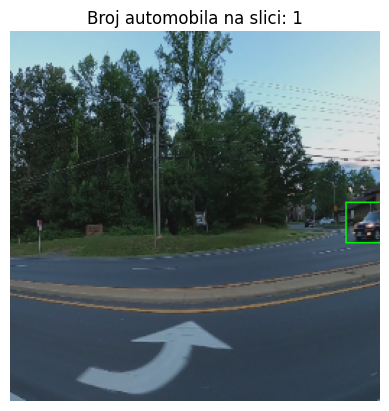

In [63]:
idx=random.randint(0,len(trainset)-1)

image, target = trainset[idx]
bbox, label = target['boxes'], target['labels']
image = image.permute(1,2,0).numpy()

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    c = (0,255,0)
    image = cv2.rectangle(image, sp, ep, c, 1)

plt.imshow(image)
plt.axis('off')
plt.title('Broj automobila na slici: '+str(len(bbox)))
plt.show()

Kada su podaci pravilno raspoređeni po datasetovima, sledeći korak je kreiranje dataloadera za trening i validaciju. Dataloader omogućava prolazak kroz podatke u vidu iteracija tokom treniranja modela. Za samo kreiranje poziva se funkcija kojoj se prosleđuju parametri o setu podataka za trening, velični batch-a, prethodno definisanoj funkciji za grupisanje podataka u batch (collate_fn) i slučajno mešanje podataka koje je postavljeno na true. Na sličan način se kreira i dataloader za validacioni set podataka, sa tim što kod validacionog seta nema potrebe za mešanjem podataka jer se njime radi evaluacija, a ne treniranje.

In [64]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, collate_fn=trainset.collate_fn ,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, collate_fn=valset.collate_fn)


Ispis broja batcheva u trening setu da bismo videli koliko puta će model prolazti kroz set tokom jedne epohe.

In [65]:

print(f"Broj batch-eva: {len(trainloader)}")

Broj batch-eva: 80


In [66]:
import torchvision

model_ssd = torchvision.models.detection.ssd300_vgg16(preTrained=True, num_classes=2)
model_ssd.to(device);

Prethodna ćelija se odnosi na upotrebu PyTorch biblioteke za kreiranje i konfiuraciju SSD modelaa za detekciju objekata. Prvo je neophodno uvesti potrebnu biblioteku, zatim se instancira model uz prosleđivanje parametara. Parametri se odnose na to da se koristi prethodno obučen model i da je broj klasa koje je neohodno detektovati jednak sa dva. Broj klasa je postavljen na dva jer se radi o binarnom problemu klasifikacije, odnosno objekat može da bude ili prisutan ili odsutan.

Sledeći blok definiše funkciju ključnu za treniranje modela. Koristi se arhitektura detektora objekta iz PyTorch torchvision biblioteke. Modul koji se uvozi služi za praćenje napretka u iteracijama kroz dataloader. Funkcija prima tri parametra, a to su model, to jest objekat koji predstavlja arhitekturu, zatim dataloader koji sadrži podatke za treniranje i optimizator koji će se koristit za optimizaciju parametara modela.

Promenljiva *train_loss* služi za praćenje ukupnog gubitka tokom treninga. For petlja služi za prolazak kroz dataloader sa trakom za vizuelizaciju napretka iteracija. U svakoj iteraciji se prenose slike i metapodaci na uređaj i računa se ukupan gubitak. Funkcija vraća prosečan trening gubitak koji se računa deljenjem ukupnog gubitka sa brojem iteracija u dataloaderu.

In [67]:
from tqdm.auto import tqdm

def trainarc(model, dataloader, opt):
    model.train() #postavlja model u režim treniranja
    train_loss=0.0

    for image, target in tqdm(dataloader):
        image = list(i.to(device) for i in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        opt.zero_grad()
        losses = model(image, target)
        loss = sum(loss for loss in losses.values()) #ukupan gubitak
        loss.backward() #gradijenti gubitka
        opt.step()

        train_loss+=loss.item()

    return train_loss/len(dataloader)

Naredni blok predstalja treniranje modela. Prvo se vrši priprema, odnosno pomoćna promenljiva za gubitak se setuje na pozitivnu beskonačnost i kreira se optimizator koji će se koristiti za ažuriranje parametara modela tokom treniranja. Broj epoha je postavljen na dva, a petlja iterira dok ne prođe kroz sve epohe. Za svaku epohu poziva se prethodno kreirana funkcija *trainarc* i ispisuje se informacija o trening gubitku. Kada se prođe kroz sve epohe, ispisuje se poruka da je treniranje završeno i podatak o najmanjem gubitku koji je postignut tokom epoha.

In [ ]:
best_train_loss = np.Inf
opt = torch.optim.Adam(model_ssd.parameters(), lr=lr)

for i in range(epochs):
    train_loss = trainarc(model_ssd, trainloader, opt)

    print(f"Epoha: {i+1}:- Trening gubitak: {train_loss}")

    if train_loss < best_train_loss:
        torch.save(model_ssd.state_dict(), '/content/drive/MyDrive/data/model_ssd.pt')
        print("Model ažuriran")
        best_train_loss = train_loss

print(f"KRAJ.\nNajmanji trening gubitak: {best_train_loss}")

  0%|          | 0/80 [00:00<?, ?it/s]

Učitavaju se prethodno sačuvane težine modela, to jest parametri iz novokreiranje datoteke *model_ssd.pt* u model. Ovo se često radi kako bi se mogao koristiti model koji je prethodno obučen ili sačuvan tokom treniranja.

In [ ]:
model_ssd.load_state_dict(torch.load('/content/drive/MyDrive/data/model_ssd.pt'))

Vrši se nasumični odabr slike iz validacionog seta podatakaz, preuzimaju se metapodaci i primenjuje se augemntacija. Zatim se tako transformisana slika prikazuje.

In [ ]:
idx=random.randint(1,len(valset)-1)
image, target = valset[idx]
image = image.permute(1,2,0).numpy()
image = test_augs(image=image)['image']

plt.imshow(image)

Sledeći korak podrazumeva transponovanje dimenzija slike i konvertovanje u PyTorch tensor. Nakon toga, slika je spremna za prosleđivanje kroz SSD model.

In [ ]:
img = torch.Tensor(np.transpose(image,(2,0,1)))


Model se postalja u režim evaluacije i modelu se zatim prosleđuje prethodno pripremljena slika. Slika se prosleđuje u vidu liste jer je model dizajniran za rad sa batch-evima slika. Rezultat je lista predikcija koje je model generisao. Pomenuta lista se i ispisuje.

In [ ]:
model_ssd.eval()
pred = model_ssd([img.to(device)])
pred

Naredni kod vrši procesuiranje predikcija dobijenih od SSD modela i prikazuje rezultate detekcije na prethodno odabranoj slici. Kao što je već poznato, prvi korak je transformacija u NumPy niz radi dalje obrade. To se radi sa slikom, *bounding box*-ovima i sa verovatnoćama. Postavlja se prag verpvatnoće na 0.4 što znači da će biti uzete u obzir samo detekcije čija je verovatnoća veća od tog broja.

Primenjuje se *Non-Maximum Suppression* - *NMS* na *bounding box*-ove kako bi se eliminisali duplikati i zadržali samo najrelevantniji objekti. Prag preklapanja je u ovom slučaju postavljen na 0.05.

Kreira se filtrirani indeks koji predstavlja prosečne indekre između onih koji su prošli *NMS* i prešli prag verovatnoće. Zatim se isti, kreirani filter primenjuje na *bounding box*-ove i verovatnoće.

Poslednji korak jeste prolazak kroz *bounding box*-ove i njohov prikaz na slici. Takođe, ispisuje se verovatnoća detekcije iznad svakog pravougaonika.

In [ ]:
image = img.permute(1,2,0).detach().cpu().numpy().copy()
bbox = pred[0]['boxes'].detach().cpu().numpy()
score = pred[0]['scores'].detach().cpu().numpy()

score_threshold = np.where(pred[0]['scores'].detach().cpu().numpy()>0.4)[0] #prag verovatnoće
ixs = nms(torch.Tensor(bbox),torch.Tensor(score),0.05)
filt = np.intersect1d(ixs, score_threshold)

bbox = bbox[filt]
score = score[filt]

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    cv2.rectangle(image, sp, ep, (0,255,0), 1)
    cv2.putText(image, str(score[i])[:4], (sp[0], sp[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)

plt.imshow(image)
plt.axis('off') #isključene oznake osa na grafiku
plt.title('Broj detekcija: ' + str(len(filt))) #naslov
plt.show()



---





> **Zaključak**




Nakon kreiranog modela, odnosno prikazanog primera rešenja problema detekcije objekata na fotografijama, može se zaključiti da tačnost modela može biti bolja. Na njegove parametre uticali su različiti faktori, kao što je, na primer, mali broj epoha. Resursi ne omogućavaju kreiranje i samo treniranje modela kroz veći, odnosno relevantan broj epoha, pa se samim tim smanjuje i tačnost predstavljenog modela.

Razni drugi faktori mogu da utiču na sam kvalitet modela, ali cilj ovog projekta jeste upoznavanje sa osnovnim konceptima računarske vizije, sticanje znanja o mogućim tehnikama i praktični pokušaj kreiranja modela, pa je sa te strane gledišta, zahtev zadatka ispunjen. Ukoliko se gleda kvalitet kreiranog modela, otvara se prostor za proširenje znanja i stvaranje modela koji će sa većom verovatnoćom odgovoriti na zahteve zadatka.

---




> **Reference**



[ 1 ]   [Mašinsko učenje](https://www.techtarget.com/searchenterpriseai/definition/machine-learning-ML)

[ 2 ]   [*Deep learning*](https://aws.amazon.com/what-is/deep-learning/)

[ 3 ]   [Računarska vizija](https://raf.edu.rs/citaliste/najnoviji-it-dogadjaji/sta-je-racunarska-vizija/)

[ 4 ]   [Detekcija objekata](https://encord.com/blog/object-detection/)

[ 5 ]   [*Bounding box*](https://www.ayadata.ai/blog-posts/bounding-boxes-in-computer-vision-uses-best-practices-for-labeling-and-more/)




---

